# Importing Libraries

In [1]:
!pip install medmnist

In [2]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1
from tensorflow.image import adjust_brightness
from tensorflow.keras import layers, models
from sklearn import metrics
from keras.layers.merge import concatenate
from matplotlib import pyplot as plt
from skimage.transform import rotate
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras.callbacks import ModelCheckpoint, Callback , EarlyStopping
from medmnist import DermaMNIST
from keras.preprocessing.image import img_to_array


import cv2
import keras.backend as K

# Loading Dataset


## Method 1 - Using wget

In [3]:
!wget -O DermaData.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2022-03-11 04:54:30--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘DermaData.npz’

DermaData.npz       100%[===================>]  18.81M  6.01MB/s    in 3.1s    

2022-03-11 04:54:36 (6.01 MB/s) - ‘DermaData.npz’ saved [19725078/19725078]



In [4]:
data = np.load('DermaData.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [5]:
X_train, y_train = data['train_images'], data['train_labels']
X_val, y_val = data['val_images'], data['val_labels']
X_test, y_test = data['test_images'], data['test_labels']

## Method 2 - Importing RetinaMNIST from MedMNIST


In [6]:
data_new_train = DermaMNIST(split='train',download=True)
data_new_val = DermaMNIST(split='val',download=True)
data_new_test = DermaMNIST(split='test',download=True)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [7]:
dataset_train = []
label_train = []
for i in data_new_train:
  dataset_train.append((img_to_array(i[0])))
  label_train.append(i[1])

In [8]:
dataset_val = []
label_val = []
for i in data_new_val:
  dataset_val.append((img_to_array(i[0])))
  label_val.append(i[1])

In [9]:
dataset_test = []
label_test = []
for i in data_new_test:
  dataset_test.append((img_to_array(i[0])))
  label_test.append(i[1])

In [10]:
train_X = np.array(dataset_train)
train_y = np.array(label_train)
val_X = np.array(dataset_val)
val_y = np.array(label_val)
test_X = np.array(dataset_test)
test_y = np.array(label_test)

## comparing datasets downloaded from different methods

In [11]:
print((train_X == X_train).all())
print((train_y == y_train).all())
print((val_X == X_val).all())
print((val_y == y_val).all())
print((test_X == X_test).all())
print((test_y == y_test).all())

True
True
True
True
True
True


## verifying the dataset

In [12]:
print(np.isnan(train_X).sum())
print(np.isnan(train_y).sum())
print(np.isnan(val_X).sum())
print(np.isnan(val_y).sum())
print(np.isnan(test_X).sum())
print(np.isnan(test_y).sum())

0
0
0
0
0
0


In [13]:
print(f'Train Set:      X:%s Y:%s' %(train_X.shape, train_y.shape))
print(f'Validation Set: X:%s  Y:%s' %(val_X.shape, val_y.shape))
print(f'Test Set :      X:%s  Y:%s' %(test_X.shape, test_y.shape))

Train Set:      X:(7007, 28, 28, 3) Y:(7007, 1)
Validation Set: X:(1003, 28, 28, 3)  Y:(1003, 1)
Test Set :      X:(2005, 28, 28, 3)  Y:(2005, 1)


# Visualizing the Dataset

In [14]:
labels = ['akiec',
          'bcc',
          'bkl',
          'df',
          'nv',
          'vasc',
          'mel']

In [15]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma'
}

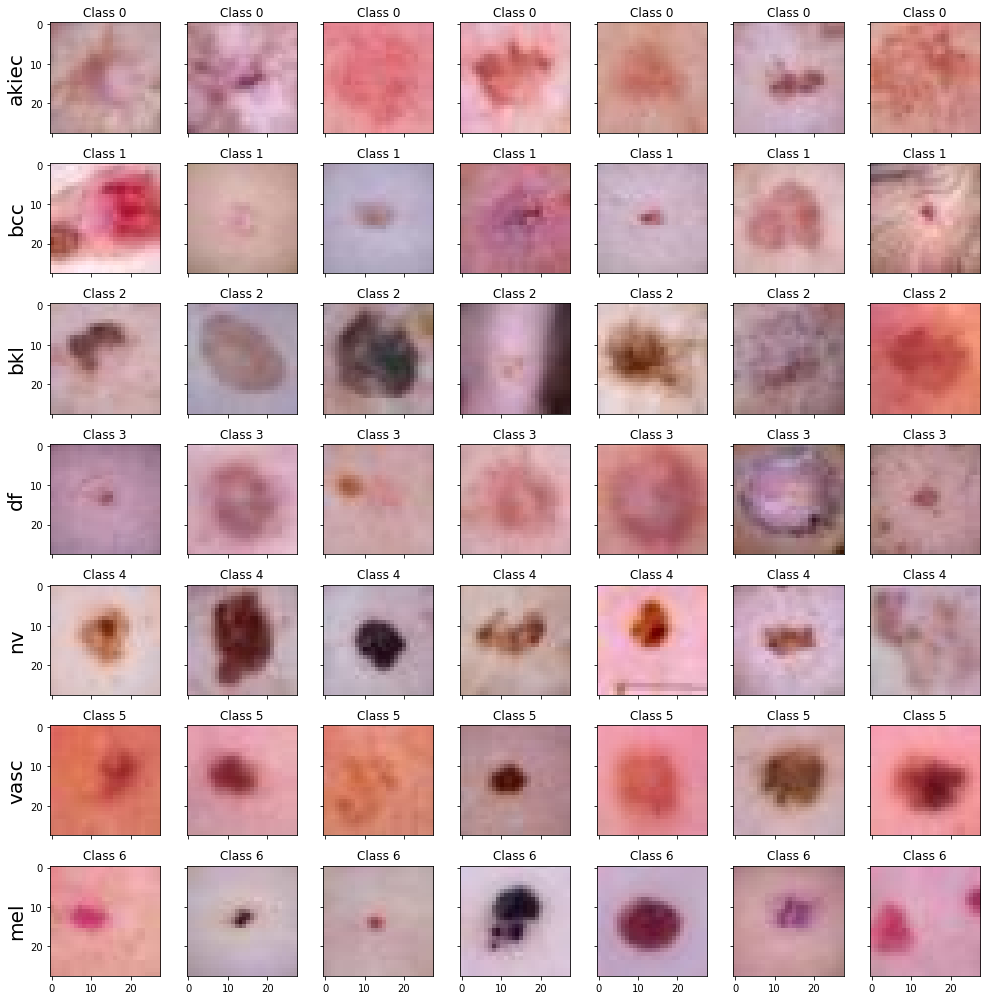

In [16]:
no_classes = len(np.unique(y_train))
fig, axes = plt.subplots(7, 7, figsize=(14, 14))
for c in range(no_classes):
    indexes = np.where(y_train == c)[0][:no_classes]
    class_images = [X_train[i] for i in indexes]
    for i in range(no_classes):
        t = f'Class {c}'
        axes[c, i].set_title(t)
        axes[c, i].imshow(class_images[i])
        axes[c,i].set_ylabel(labels[c],fontsize = 20.0)
        axes[c,i].label_outer()
plt.tight_layout()

# Data Pre-Processing

## Checking for different samples available for each label

In [17]:
def get_classes_dist(y):
    count = [0 for i in range(7)]
    for i in y:
      count[i] += 1
    return count

In [18]:
print(f"Train      => {get_classes_dist(train_y.reshape(-1,))}")
print(f"Validation => {get_classes_dist(val_y.reshape(-1,))}")
print(f"Test       => {get_classes_dist(test_y.reshape(-1,))}")

Train      => [228, 359, 769, 80, 779, 4693, 99]
Validation => [33, 52, 110, 12, 111, 671, 14]
Test       => [66, 103, 220, 23, 223, 1341, 29]


## Data Augmentation for all the classes execpt 'vasc' and also removing some samples from 'vasc'

In [19]:
# Removing some data from 'Vasc class'
count = 1
i = 0
X_train2 = X_train
y_train2 = y_train
indexes = []

while count <= (2800):
    if y_train[i] == 5:
        indexes.append(i)
        count += 1
    i += 1

X_train2 = np.delete(X_train2, indexes, axis=0)
y_train2 = np.delete(y_train2, indexes, axis=0)

In [20]:
X_augmented = X_train2
y_augmented = y_train2.reshape(-1,)

for i in range(X_train2.shape[0]):
    y = y_train2.reshape(-1,)[i]
    if y == 5:
        continue
    elif y == 0:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], X_train2[i][::-1, :,:], adjust_brightness(X_train2[i], delta=0.3), adjust_brightness(X_train2[1], delta=-0.3)], axis=0)
        X_augmented = np.append(X_augmented, [rotate(X_train2[i], 45), rotate(X_train2[i], 90)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y, y, y, y], axis=0)
    elif y == 1:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], adjust_brightness(X_train2[i], delta=0.3),rotate(X_train2[i], 45)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y], axis=0)
    elif y == 2:
         X_augmented = np.append(X_augmented, [adjust_brightness(X_train2[i], delta=0.3)], axis=0)
         y_augmented = np.append(y_augmented, [y], axis=0)
    elif y == 3:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], X_train2[i][::-1, :,:], adjust_brightness(X_train2[i], delta=0.3), adjust_brightness(X_train2[1], delta=-0.3),adjust_brightness(X_train2[1], delta=0.2)], axis=0)
        X_augmented = np.append(X_augmented, [rotate(X_train2[i], 45), rotate(X_train2[i], 90), adjust_brightness(X_train2[i], delta=-0.6), rotate(X_train2[i], 135), adjust_brightness(X_train2[i], delta=0.6)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y, y, y, y, y, y, y], axis=0)
    elif y == 4:
        X_augmented = np.append(X_augmented, [adjust_brightness(X_train2[i], delta=0.3)], axis=0)
        y_augmented = np.append(y_augmented, [y], axis=0)
    elif y == 6:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], X_train2[i][::-1, :,:], adjust_brightness(X_train2[i], delta=0.3), adjust_brightness(X_train2[1], delta=-0.3)], axis=0)
        X_augmented = np.append(X_augmented, [rotate(X_train2[i], 45), rotate(X_train2[i], 90), adjust_brightness(X_train2[i], delta=-0.6), rotate(X_train2[i], 135), adjust_brightness(X_train2[i], delta=0.6)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y, y, y, y, y, y, y], axis=0)

In [21]:
print(f"Shape of dataset after augmentation => {X_augmented.shape}")
print(f"Different Labels => {get_classes_dist(y_augmented.reshape(-1,))}")

Shape of dataset after augmentation => (9891, 28, 28, 3)
Different Labels => [1596, 1436, 1538, 800, 1558, 1893, 990]


## Normalization

In [22]:
feature_train = train_X/255
feature_test = test_X/255
feature_val = val_X/255
feature_aug = X_augmented/255

## One Hot Encoding

In [23]:
target_train = tf.keras.utils.to_categorical(train_y)
target_val = tf.keras.utils.to_categorical(val_y)
target_test = tf.keras.utils.to_categorical(test_y)
target_aug = tf.keras.utils.to_categorical(y_augmented)

# Defining custom Evaluation Metrics, Optimizers, EarlyStopping

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
opt_r = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
opt_a = tf.keras.optimizers.Adamax(learning_rate = 0.0001)
opt_s = tf.keras.optimizers.SGD(learning_rate = 0.005)

In [25]:
callbacks = [EarlyStopping ( monitor = "val_loss", patience= 5)]

In [26]:
width, height, channels = 28,28,3
if K.image_data_format() == 'channels_first':
    input_shape = (channels, width, height)
else:
    input_shape = (width, width, channels)

# Sequential CNN (Model 1)

In [27]:
network_seq = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape= input_shape, padding='same', kernel_regularizer=l2(0.01)),
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),            
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),            
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),        
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(1000, 'relu'),
            layers.Dropout(0.2),
            layers.Dense(300, 'relu'),
            layers.Dropout(0.2),
            layers.Dense(100, 'relu'),
            layers.Dropout(0.5),
            layers.Dense(40, 'relu'),
            layers.Dense(7, 'softmax')
])

In [28]:
network_seq.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy',Recall(), Precision(), AUC()])

In [29]:
history_seq = network_seq.fit(feature_train, target_train, epochs=40, batch_size=16, validation_data=(feature_val, target_val),callbacks=callbacks)

Epoch 1/40
438/438 [==============================] - 14s 23ms/step - loss: 1.6088 - accuracy: 0.6685 - recall: 0.5076 - precision: 0.7322 - auc: 0.8752 - val_loss: 1.4660 - val_accuracy: 0.6690 - val_recall: 0.3789 - val_precision: 0.9048 - val_auc: 0.9135
Epoch 2/40
438/438 [==============================] - 9s 20ms/step - loss: 1.3589 - accuracy: 0.6698 - recall: 0.5379 - precision: 0.7828 - auc: 0.9059 - val_loss: 1.2710 - val_accuracy: 0.6690 - val_recall: 0.4845 - val_precision: 0.8394 - val_auc: 0.9217
Epoch 3/40
438/438 [==============================] - 9s 22ms/step - loss: 1.2611 - accuracy: 0.6700 - recall: 0.5492 - precision: 0.8120 - auc: 0.9135 - val_loss: 1.2001 - val_accuracy: 0.6690 - val_recall: 0.5234 - val_precision: 0.8294 - val_auc: 0.9252
Epoch 4/40
438/438 [==============================] - 9s 21ms/step - loss: 1.1875 - accuracy: 0.6700 - recall: 0.5707 - precision: 0.8141 - auc: 0.9205 - val_loss: 1.1304 - val_accuracy: 0.6690 - val_recall: 0.5643 - val_precisi

In [30]:
training_loss = history_seq.history["loss"]
test_loss = history_seq.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

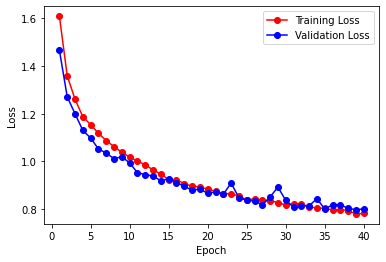

In [31]:
# visualise loss history
plt.plot(epoch_count, training_loss, "r-o")
plt.plot(epoch_count, test_loss, "b-o")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

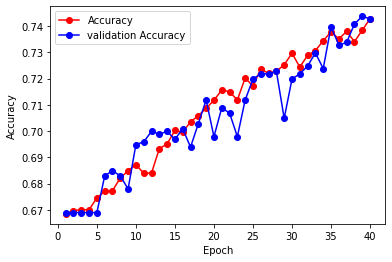

In [32]:
training_accuracy= history_seq.history["accuracy"]
testing_accuracy= history_seq.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r-o")
plt.plot(epoch_count, testing_accuracy, "b-o")
plt.legend(["Accuracy", "validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

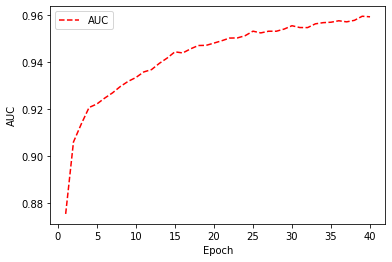

In [33]:
plt.plot(epoch_count, history_seq.history["auc"], "r--")
plt.legend(["AUC"])
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

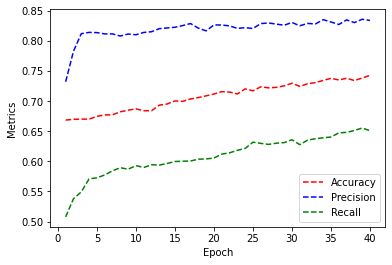

In [34]:
training_accuracy= history_seq.history["accuracy"]
training_precision= history_seq.history["precision"]
training_recall= history_seq.history["recall"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, training_precision, "b--")
plt.plot(epoch_count, training_recall, "g--")
plt.legend(["Accuracy", "Precision","Recall"])
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.show()

In [35]:
score_seq  = network_seq.evaluate(feature_test, target_test,verbose = 0)
print(f"Test Accuracy : {np.round(score_seq[1],2)}")
print(f"Test Recall : {np.round(score_seq[2],2)}")
print(f"Test Precision : {np.round(score_seq[3],2)}")
print(f"Test AUC : {np.round(score_seq[4],2)}")

Test Accuracy : 0.75
Test Recall : 0.61
Test Precision : 0.86
Test AUC : 0.96


In [36]:
ypred_seq = network_seq.predict(feature_test)
classes_x_seq=np.argmax(ypred_seq,axis=1)
target = np.argmax(target_test, axis = 1)

In [37]:
print(f"Number of correct labels predicted : {(target == classes_x_seq).sum()} out of 2005")

Number of correct labels predicted : 1495 out of 2005


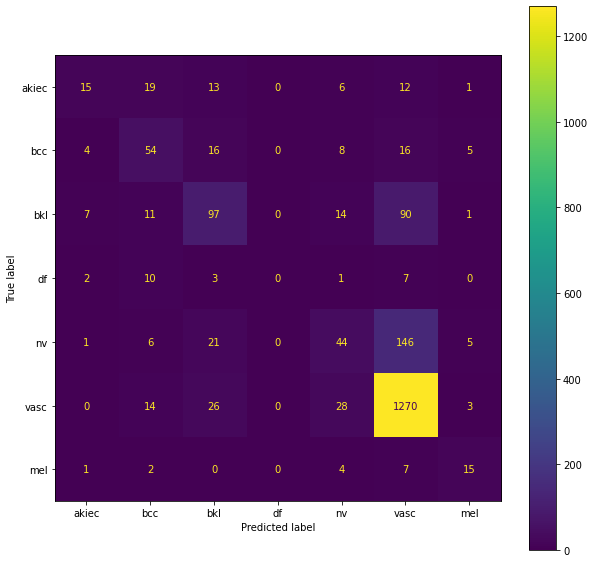

In [38]:
cm = confusion_matrix(target,classes_x_seq)
cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)

In [39]:
print(classification_report(target, classes_x_seq,target_names = labels))

              precision    recall  f1-score   support

       akiec       0.50      0.23      0.31        66
         bcc       0.47      0.52      0.49       103
         bkl       0.55      0.44      0.49       220
          df       0.00      0.00      0.00        23
          nv       0.42      0.20      0.27       223
        vasc       0.82      0.95      0.88      1341
         mel       0.50      0.52      0.51        29

    accuracy                           0.75      2005
   macro avg       0.47      0.41      0.42      2005
weighted avg       0.70      0.75      0.71      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


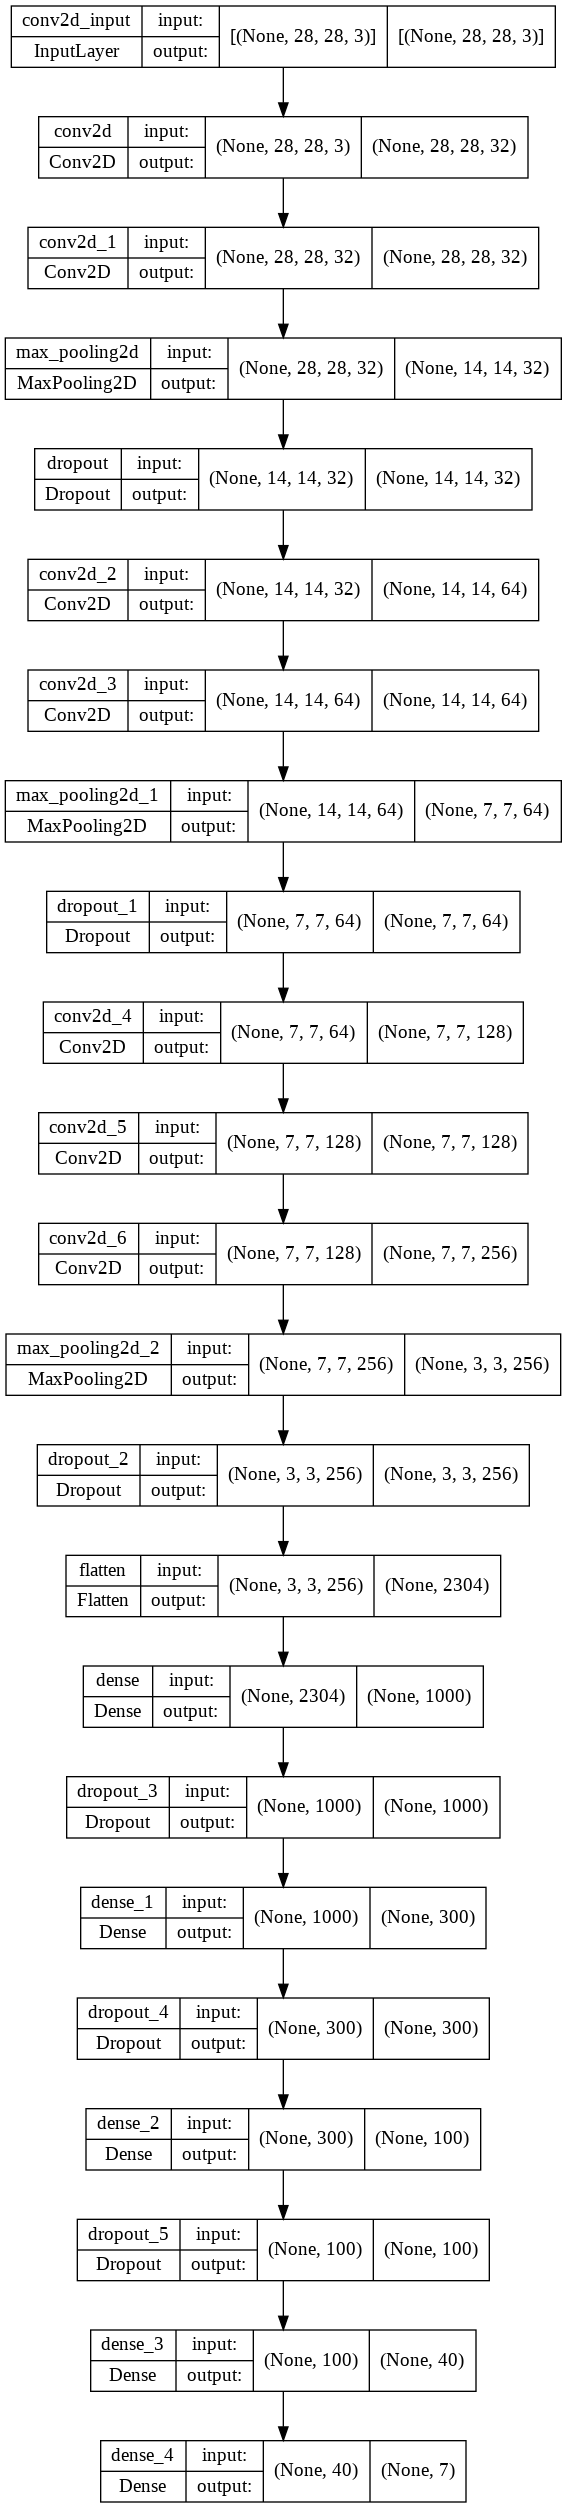

In [40]:
tf.keras.utils.plot_model(network_seq, show_shapes=True)

In [41]:
network_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [42]:
#network_seq.save('sequential_72_derma.h5')

# Sequential CNN where input is 32*32 (Model 2)

## Changing sizes and pre-processing

In [43]:
X_train_reshape = np.array([cv2.resize(img, (32, 32)) for img in X_train])
X_val_reshape = np.array([cv2.resize(img, (32, 32)) for img in X_val])
X_test_reshape = np.array([cv2.resize(img, (32, 32)) for img in X_test])
X_augmented_reshape = np.array([cv2.resize(img, (32, 32)) for img in X_augmented])
X_train_reshape.shape, X_val_reshape.shape, X_test_reshape.shape,X_augmented_reshape.shape

((7007, 32, 32, 3), (1003, 32, 32, 3), (2005, 32, 32, 3), (9891, 32, 32, 3))

In [44]:
feature_test_reshape = X_test_reshape/255
feature_train_reshape = X_train_reshape/255
feature_val_reshape = X_val_reshape/255
feature_aug_reshape = X_augmented_reshape/255

In [45]:
network_seq_resize = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', padding='same', input_shape= (32,32,3), kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),         
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),          
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),       
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            
            layers.Flatten(),
            layers.Dense(50, 'elu'),
            layers.Dense(7, 'softmax')
])

In [46]:
callbacks = [EarlyStopping ( monitor = "val_loss", patience= 5)]

In [47]:
network_seq_resize.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss="categorical_crossentropy", 
              metrics=['accuracy',Recall(), Precision(), AUC()])

In [48]:
history_seq_resize =  network_seq_resize.fit(
            feature_train_reshape, target_train, 
            epochs=40, 
            batch_size=32, 
            validation_data=(feature_val_reshape, target_val),callbacks=callbacks)

Epoch 1/40
219/219 [==============================] - 8s 28ms/step - loss: 1.4704 - accuracy: 0.6622 - recall_1: 0.5746 - precision_1: 0.7602 - auc_1: 0.9109 - val_loss: 1.3473 - val_accuracy: 0.6790 - val_recall_1: 0.5833 - val_precision_1: 0.8170 - val_auc_1: 0.9266
Epoch 2/40
219/219 [==============================] - 5s 21ms/step - loss: 1.3104 - accuracy: 0.6729 - recall_1: 0.5827 - precision_1: 0.7907 - auc_1: 0.9270 - val_loss: 1.2331 - val_accuracy: 0.6800 - val_recall_1: 0.6351 - val_precision_1: 0.7684 - val_auc_1: 0.9353
Epoch 3/40
219/219 [==============================] - 5s 21ms/step - loss: 1.1960 - accuracy: 0.6885 - recall_1: 0.5914 - precision_1: 0.8091 - auc_1: 0.9341 - val_loss: 1.1008 - val_accuracy: 0.6969 - val_recall_1: 0.5972 - val_precision_1: 0.8161 - val_auc_1: 0.9442
Epoch 4/40
219/219 [==============================] - 5s 21ms/step - loss: 1.0957 - accuracy: 0.6984 - recall_1: 0.6028 - precision_1: 0.8006 - auc_1: 0.9406 - val_loss: 1.0712 - val_accuracy: 

In [49]:
training_loss = history_seq_resize.history["loss"]
test_loss = history_seq_resize.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

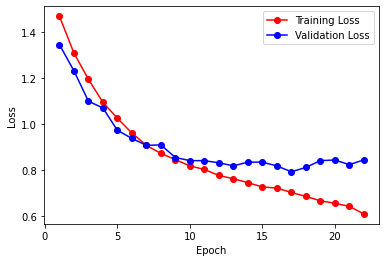

In [50]:
# visualise loss history
plt.plot(epoch_count, training_loss, "r-o")
plt.plot(epoch_count, test_loss, "b-o")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

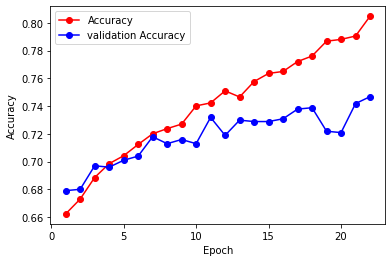

In [51]:
training_accuracy= history_seq_resize.history["accuracy"]
testing_accuracy= history_seq_resize.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r-o")
plt.plot(epoch_count, testing_accuracy, "b-o")
plt.legend(["Accuracy", "validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

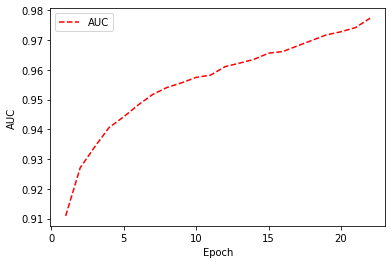

In [52]:
plt.plot(epoch_count, history_seq_resize.history["auc_1"], "r--")
plt.legend(["AUC"])
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

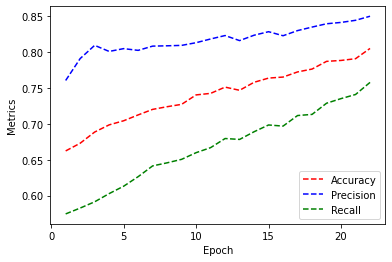

In [53]:
training_accuracy= history_seq_resize.history["accuracy"]
training_precision= history_seq_resize.history["precision_1"]
training_recall= history_seq_resize.history["recall_1"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, training_precision, "b--")
plt.plot(epoch_count, training_recall, "g--")
plt.legend(["Accuracy", "Precision","Recall"])
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.show()

In [54]:
score_seq_size  = network_seq_resize.evaluate(feature_test_reshape, target_test,verbose = 0)
print(f"Test Accuracy : {np.round(score_seq_size[1],2)}")
print(f"Test Recall : {np.round(score_seq_size[2],2)}")
print(f"Test Precision : {np.round(score_seq_size[3],2)}")
print(f"Test AUC : {np.round(score_seq_size[4],2)}")

Test Accuracy : 0.74
Test Recall : 0.71
Test Precision : 0.78
Test AUC : 0.95


In [55]:
ypred_seq_resize = network_seq_resize.predict(feature_test_reshape)
classes_x_seq_resize=np.argmax(ypred_seq_resize,axis=1)
target = np.argmax(target_test, axis = 1)

In [56]:
print(f"Number of correct labels predicted : {(target == classes_x_seq_resize).sum()} out of 2005")

Number of correct labels predicted : 1474 out of 2005


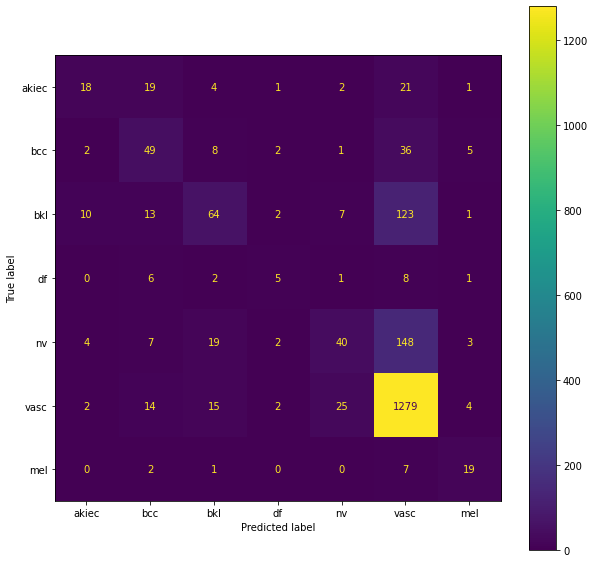

In [57]:
cm = confusion_matrix(target,classes_x_seq_resize)
cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)

In [58]:
print(classification_report(target, classes_x_seq_resize,target_names = labels))

              precision    recall  f1-score   support

       akiec       0.50      0.27      0.35        66
         bcc       0.45      0.48      0.46       103
         bkl       0.57      0.29      0.38       220
          df       0.36      0.22      0.27        23
          nv       0.53      0.18      0.27       223
        vasc       0.79      0.95      0.86      1341
         mel       0.56      0.66      0.60        29

    accuracy                           0.74      2005
   macro avg       0.53      0.44      0.46      2005
weighted avg       0.70      0.74      0.70      2005



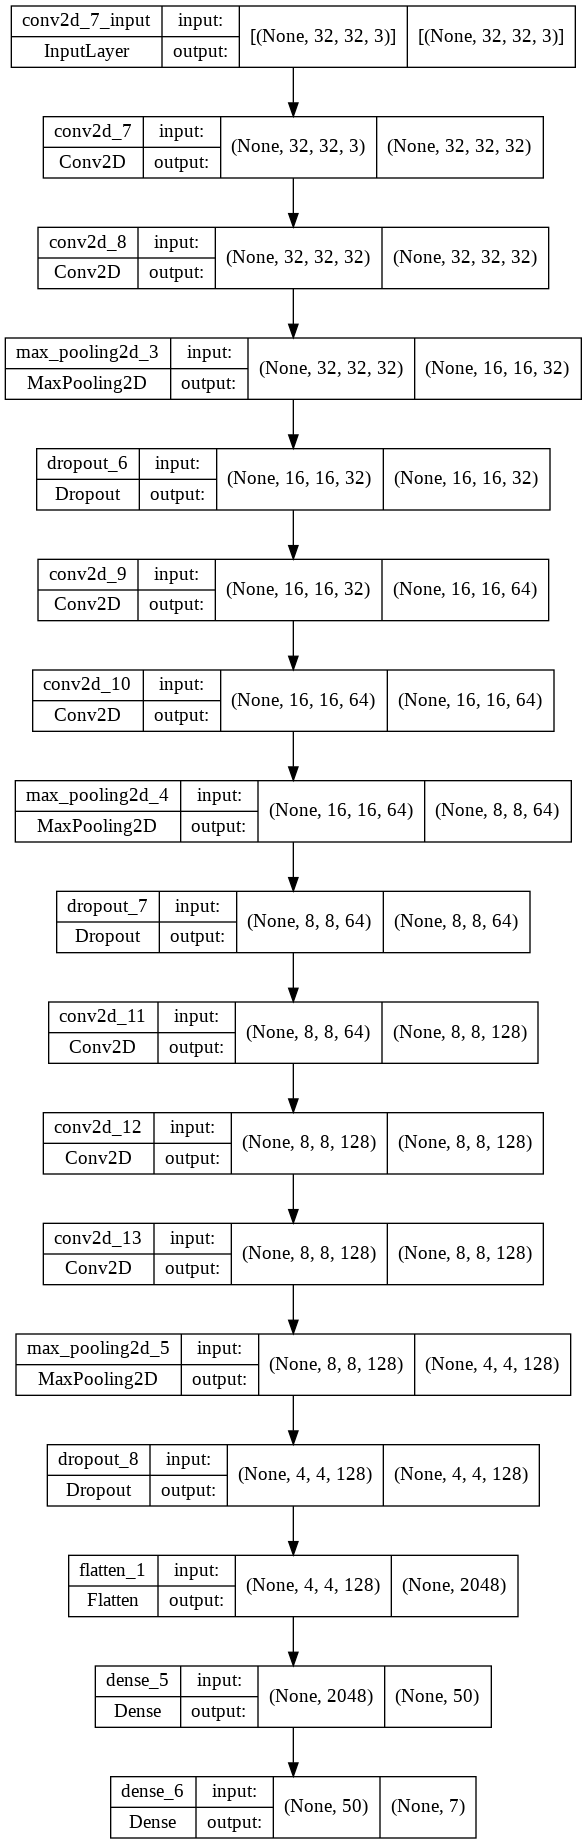

In [59]:
tf.keras.utils.plot_model(network_seq_resize, show_shapes=True)

In [60]:
network_seq_resize.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [61]:
#network_seq_resize.save('derma_best_seq_32x32.h5')